## HT Correction V2.5
Doing some more testing with the previous method of change in tail position marker to ensure that the hunch is correct. Tested the ht_correction function on 3 videos where the script didn't catch over 50% of errors. Thus, officially moving on to using "blinks" as markers. 

Also realized that the video file for unprocessed and processed data is very different. Processed data will smooth the larva movements and remove instances when the larva "blinks." With this realization, it is important for lab memebers to first run the error correction script with unprocessed data THEN run the processing script to smoothen movements. 

In [1]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from numpy import diff
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *

In [2]:
# original data
data = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data_processed.csv')
filename = "2021.09.08_12-49-52_data_processed.csv"

In [8]:
# Filtering processed data
Xcentroid = pd.Series(data['X-Centroid'])
Ycentroid = pd.Series(data['Y-Centroid'])
Xhead = pd.Series(data['X-Head'])
Yhead = pd.Series(data['Y-Head'])
Xtail = pd.Series(data['X-Tail'])
Ytail = pd.Series(data['Y-Tail'])
frame = pd.Series(data['Frame'])

In [4]:
# Function to find distance bewteen two frames
def dis(x1, y1, x2, y2):
    dist = (((x1-x2)**2 + (y1-y2)**2)**(1/2))
    return dist

In [5]:
# function to create change in tailPosition data
def tail_position_change(xt, yt, frame):
    tailPosition = []
    
    if frame[0] != 0: # if frame doesn't start at 0 ##edit by Zainab (changed for loop to if loop)
        tailPosition.append(0)
    
    for i in range(len(xt)-1):
        dist = dis(xt[i], yt[i], xt[i+1], yt[i+1])
        tailPosition.append(dist)
    
    return tailPosition

In [6]:
# function to make a plot for tailPosition data
def plot_tail_change(tail_data, string):
    xlist = np.linspace(frame[0], frame[0]+len(tail_data), len(tail_data)) # frames as x
    ylist = tail_data # change in tail position as y

    fig, ax = plt.subplots()
    ax.plot(xlist, ylist, linewidth=2.0)
    fig.savefig(string + '.png') # edit by Zainab - just added a line to save the figures (you'll have to input a string name for the file into this function now)

    plt.show()

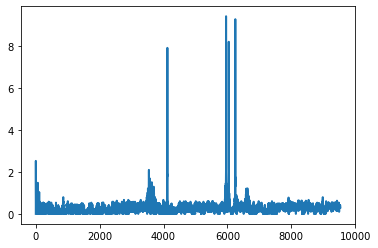

0.29137432773454314 0.27430597569282994


In [7]:
# create data and plot it
tchange = tail_position_change(Xtail, Ytail, frame)
tchange_plot = plot_tail_change(tchange, 'output')

mean, stdev = np.mean(tchange, axis=0), np.std(tchange, axis=0)
print(mean, stdev)

In [8]:
# Find the peaks (relative max) 
def find_peaks(tchange, frame_num):

    peaks = (diff(sign(diff(tchange))) < 0).nonzero()[0] + 1 

    # Find peaks greater than threshold (temporarily set at 4)
    big_peaks = []
    for frame_num in peaks:
        if tchange[frame_num] > 4:
            big_peaks.append(frame_num)
            
    return big_peaks

In [9]:
find_peaks(tchange, frame)[::2]

[4118, 6038]

In [12]:
# error start is every even index (ie. bigpeak[0], bigpeaks[2], etc)
#error_start = big_peaks[::2]
# error end is every odd index (ie. bigpeak[1], bigpeaks[3], etc)
#error_end = big_peaks[1::2]

# now taking what you write for ht_corrections and using the error_start and error_end from ^
def ht_correction(filename, xc, yc, xh, yh, xt, yt, frame):
    
    xheadCorrected = xh.copy()
    yheadCorrected = yh.copy()
    xtailCorrected = xt.copy()
    ytailCorrected = yt.copy()
    
    # plot change in tail position without corrections
    tchange = tail_position_change(xt, yt, frame)
    tchange_plot = plot_tail_change(tchange, 'output1')
    
    # identify peaks
    find_peaks(tchange, frame)
            
    # error start is every even index (ie. bigpeak[0], bigpeaks[2], etc)
    error_start = find_peaks(tchange, frame)[::2]
    # error end is every odd index (ie. bigpeak[1], bigpeaks[3], etc)
    error_end = find_peaks(tchange, frame)[1::2]
    
    for i in range(len(error_start)):
        xheadCorrected[error_start[i]:error_end[i]] = xt[error_start[i]:error_end[i]]
        yheadCorrected[error_start[i]:error_end[i]] = yt[error_start[i]:error_end[i]]
        xtailCorrected[error_start[i]:error_end[i]] = xh[error_start[i]:error_end[i]]
        ytailCorrected[error_start[i]:error_end[i]] = yh[error_start[i]:error_end[i]]
    
    # plot change in tail position WITH corrections
    tchange1 = tail_position_change(xtailCorrected, ytailCorrected, frame)
    tchange_plot1 = plot_tail_change(tchange1, 'output2')
    
    '''
    # finding peaks (if any) in the new set
    peaks1 = (diff(sign(diff(tchange1))) < 0).nonzero()[0] + 1
    
    new_peaks = []
    for frame in peaks1:
        if tchange1[frame] > 4:
            new_peaks.append(frame)
        
    print(new_peaks)
    '''
    
    # plot trajectory
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    ax1.plot(xh, yh)
    ax1.plot(xt, yt)
    plt.title("trajectory before HT error correction")
    
    ax2.plot(xheadCorrected, yheadCorrected) # blue
    ax2.plot(xtailCorrected, ytailCorrected) # orange
    plt.title("trajectory after HT error correction")
    plt.show
    
    #filename for the corrected file:
    fileparts = filename.split('.')
    first_part = '.'.join(fileparts[0:len(fileparts) - 1])
    second_part = "_HTcorrected"
    filename_corrected = '.'.join([first_part + second_part, fileparts[-1]]) #a way to rename the corrected file
    #below is a way to name the heading (first) row of the new csv file:
    newCorrectedArray = {
        'xCentroid' : list(np.round(xc,decimals=1)),
        'yCentroid' : list(np.round(xc,decimals=1)),
        'xHeadCorrected' : xheadCorrected,
        'yHeadCorrected' : yheadCorrected,
        'xTailCorrected' : xtailCorrected,
        'yTailCorrected' : ytailCorrected
    }
    #putting the actual data of corrected xy values in the array first:
    df = pd.DataFrame(newCorrectedArray)
    #and then put it in a csv of the new filename:
    df.to_csv(filename_corrected)


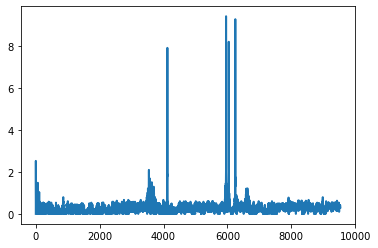

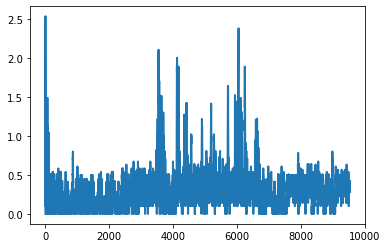

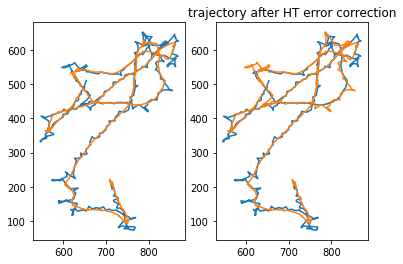

In [11]:
ht_correction(filename, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frame)

# plot trajectory of before and after the change
# mean + 2(stdev)
# set threshold through case specific manner w trial and error
# try to first get it working for 3-4 cases

In [14]:
Xcentroid1 = Xcentroid[3540:3570]
Ycentroid1 = Ycentroid[3540:3570]
Xhead1 = Xhead[3540:3600]
Yhead1 = Yhead[3540:3570]
Xtail1 = Xtail[3540:3570]
Ytail1 = Ytail[3540:3570]
frames1 = frame[3540:3570]

In [15]:
ht_correction(filename, Xcentroid1, Ycentroid1, Xhead1, Yhead1, Xtail1, Ytail1, frames1)

KeyError: 0

## Test on more trajectory's

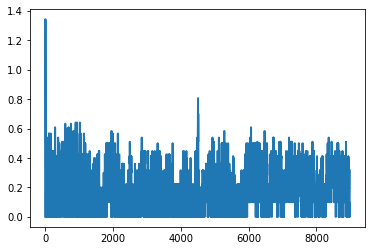

[]

In [13]:
data1 = pd.read_csv("2021.07.26_23-28-46_test/2021.07.26_23-28-46_data_processed.csv")

Xcentroid1 = pd.Series(data1['X-Centroid'])
Ycentroid1 = pd.Series(data1['Y-Centroid'])
Xhead1 = pd.Series(data1['X-Head'])
Yhead1 = pd.Series(data1['Y-Head'])
Xtail1 = pd.Series(data1['X-Tail'])
Ytail1 = pd.Series(data1['Y-Tail'])
frame1 = pd.Series(data1['Frame'])
filename1 = "2021.07.26_23-28-46_data_processed.csv"

tchange1 = tail_position_change(Xtail1, Ytail1, frame1)
#find_peaks(tchange1, frame1)
plot_tail_change(tchange1, 'output')
np.mean(tchange1)
#ht_correction(filename1, Xcentroid1, Ycentroid1, Xhead1, Yhead1, Xtail1, Ytail1, frame1)
find_peaks(tchange1, frame1)

# starts high but isn't actually an error, second peak is an actual error
# adding condition to ignore initial and ending 
# if n=1 then just correct that
# 1) mean + stdev *
# 2) use sids peak method
# 3) aim for solving 80% of the erorrs (not all)

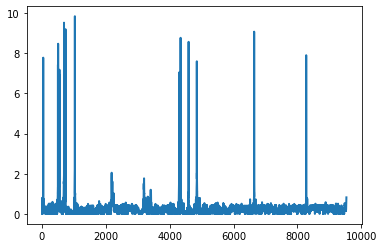

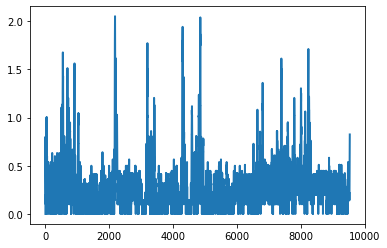

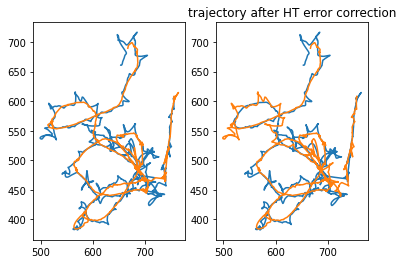

In [13]:
data2 = pd.read_csv("2021.09.09_12-51-26_W1118_Odor/2021.09.09_12-51-26_data_processed.csv")

Xcentroid2 = pd.Series(data2['X-Centroid'])
Ycentroid2 = pd.Series(data2['Y-Centroid'])
Xhead2 = pd.Series(data2['X-Head'])
Yhead2 = pd.Series(data2['Y-Head'])
Xtail2 = pd.Series(data2['X-Tail'])
Ytail2 = pd.Series(data2['Y-Tail'])
frame2 = pd.Series(data2['Frame'])

#tchange2 = tail_position_change(Xtail2, Ytail2, frame2)
#plot_tail_change(tchange2, 'output')

ht_correction(Xcentroid2, Ycentroid2, Xhead2, Yhead2, Xtail2, Ytail2, frame2)

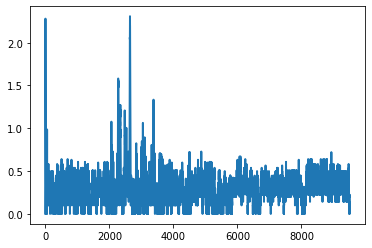

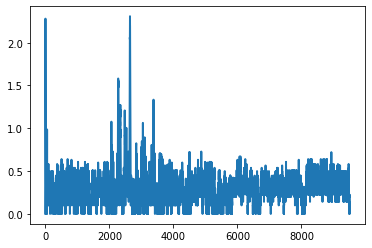

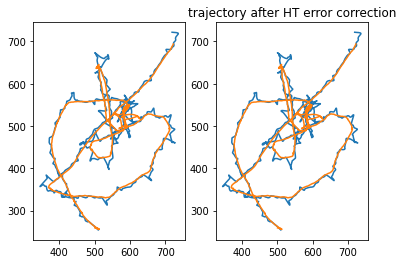

In [20]:
data3 = pd.read_csv("2021.10.04_15-08-01_W1118 Odor/2021.10.04_15-08-01_data_processed.csv")

Xcentroid3 = pd.Series(data3['X-Centroid'])
Ycentroid3 = pd.Series(data3['Y-Centroid'])
Xhead3 = pd.Series(data3['X-Head'])
Yhead3 = pd.Series(data3['Y-Head'])
Xtail3 = pd.Series(data3['X-Tail'])
Ytail3 = pd.Series(data3['Y-Tail'])
frame3 = pd.Series(data3['Frame'])

ht_correction(Xcentroid3, Ycentroid3, Xhead3, Yhead3, Xtail3, Ytail3, frame3)

## Notes
- for data3 there are errors that occur at the "obvious" peaks
    - use some statistical method to determine what should be determined as peaks (any suggestions)
    - mean and stdv
- is there a way to see the new csv played in pivr?
- using len(error_start) won't work if there's odd number of peaks bc error_end will go out of range (write if function to address it)

## Swapping Unprocessed Data

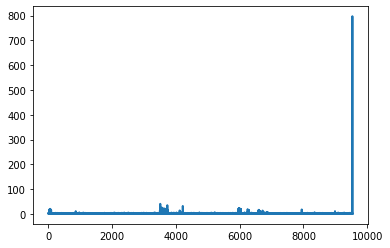

IndexError: list index out of range

In [15]:
up_data = pd.read_csv("2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data.csv")
up_filename = "2021.09.08_12-49-52_data.csv"

up_Xcentroid = pd.Series(up_data['X-Centroid'])
up_Ycentroid = pd.Series(up_data['Y-Centroid'])
up_Xhead = pd.Series(up_data['X-Head'])
up_Yhead = pd.Series(up_data['Y-Head'])
up_Xtail = pd.Series(up_data['X-Tail'])
up_Ytail = pd.Series(up_data['Y-Tail'])
up_frame = pd.Series(up_data['Frame'])

ht_correction(up_filename, up_Xcentroid, up_Ycentroid, up_Xhead, up_Yhead, up_Xtail, up_Ytail, up_frame)